In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Analysis with real life option data

The data are sourced from OptionMetrics Ivy DB US, accessed using Wharton Research Data Services.

In [2]:
# Load the CSV file
data_options_path = os.path.expanduser("~/Downloads/qkn5ldiosjukbckd.csv")
data_security_path = os.path.expanduser("~/Downloads/dkpteihlwrfnfwst.csv")

# Read the data
df_options = pd.read_csv(data_options_path, encoding='utf-8')
df_security = pd.read_csv(data_security_path, encoding='utf-8')
starting_date = df_options['date'].unique()[0]

# Filter out tickers that are not suitable for Black-Scholes analysis
# Reasons for exclusion:
# - European-style options: SPX, DJX (indices)
# - Significant dividend payers: PG, JNJ, AAPL, F
# (European Black-Scholes doesn't account for dividends or American early exercise)
excluded_tickers = ['SPX', 'DJX', 'PG', 'JNJ', 'F', 'AAPL']
included_tickers = ['AMZN', 'MSFT', 'NVDA', 'TSLA', 'META']#df_options['ticker'].unique().tolist()

df_options = df_options[df_options['ticker'].isin(included_tickers)]
df_security = df_security[df_security['ticker'].isin(included_tickers)]

print(f"Data loaded successfully!")
print(f"Included tickers: {', '.join(included_tickers)}")
print(f"Options Data Shape: {df_options.shape[0]} rows × {df_options.shape[1]} columns")
print(f"Security Data Shape: {df_security.shape[0]} rows × {df_security.shape[1]} columns")

Data loaded successfully!
Included tickers: AMZN, MSFT, NVDA, TSLA, META
Options Data Shape: 15766 rows × 38 columns
Security Data Shape: 1260 rows × 19 columns


/var/folders/z4/h6nt6cb92jl9jsxg6g7h076m0000gp/T/ipykernel_67875/923890359.py:6: DtypeWarning: Columns (32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_options = pd.read_csv(data_options_path, encoding='utf-8')


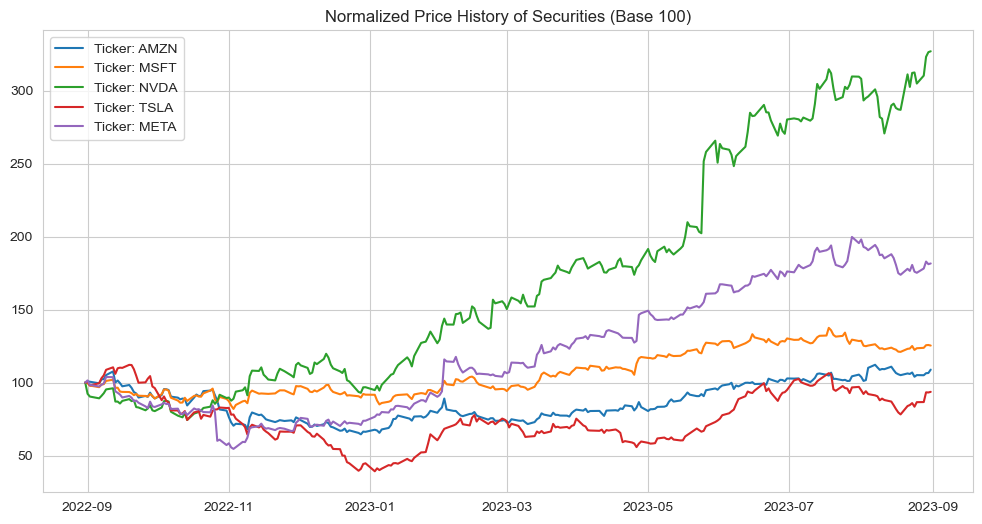

In [3]:
# Test: plot the price history of the securities
# for all security id, plot the close price history
for secid in df_security['secid'].unique():
    price_history = df_security[df_security['secid'] == secid]['close']
    normalized_price = (price_history / price_history.iloc[0]) * 100
    ticker = df_security[df_security['secid'] == secid]['ticker'].values[0]
    time = pd.to_datetime(df_security[df_security['secid'] == secid]['date'])
    plt.plot(time, normalized_price, label=f'Ticker: {ticker}')
plt.title("Normalized Price History of Securities (Base 100)")
plt.legend()
plt.show()

The interest rate is obtained from the zero-coupon yield curve for the bond with the contract length closest to the option.

In [ ]:
# Test: examine the call option prices
# The option price should yield some measures of implied volatility using Black-Scholes model
from src.black_scholes import implied_volatility_call

def get_interest_rate(contract_length, data_rate = os.path.expanduser("~/Downloads/zerocouponyieldcurve.csv")):
    df_rate = pd.read_csv(data_rate, encoding='utf-8')
    df_rate_start = df_rate[df_rate['date'] == starting_date].copy()
    # Find the closest rate entry based on contract length
    days_diff = np.abs(df_rate_start['days'] - contract_length)
    closest_idx = days_diff.idxmin()
    closest_rate_entry = df_rate_start.loc[closest_idx]
    r = closest_rate_entry['rate'] / 100  # Convert percentage to decimal
    return r, closest_rate_entry


def get_implied_volatilities_for_ticker_and_exdate(ticker, target_exdate = None, exdate_id = None, verbose = False):
    """
    Calculate implied volatilities for call options given a ticker and target expiration date.
    
    Parameters:
    -----------
    ticker : str
        Ticker symbol (e.g., 'AMZN', 'MSFT')
    target_exdate : str or datetime-like, optional
        Target expiration date. The function will find the closest available expiration date.
        Can be in format 'YYYY-MM-DD' or any format parseable by pd.to_datetime()
    exdate_id : int, optional
        If provided, use this index to select expiration date instead of target_exdate.
        Note: only one of target_exdate or exdate_id should be provided.
    
    Returns:
    --------
    tuple : (call_entries, spot_price, r, t, actual_exdate)
        call_entries : DataFrame with call options and calculated implied volatilities
        spot_price : float, current spot price of the stock
        r : float, risk-free interest rate
        t : float, time to expiration in years
        actual_exdate : str, the actual expiration date used (closest to target)
    """
    if target_exdate is None and exdate_id is None:
        raise ValueError("Either target_exdate or exdate_id must be provided.")
    if target_exdate is None and exdate_id is not None:
        raise ValueError("Only one of target_exdate or exdate_id must be provided.")
    #secid = 101310
    df_options_secid = df_options[df_options['ticker'] == ticker]
    secid = df_security[df_security['ticker'] == ticker]['secid'].values[0]
    if verbose:
        print(f"Analyzing options for secid: {secid}, ticker: {ticker}")

    if exdate_id is None:
    # Convert target_exdate to datetime for comparison
        target_exdate_dt = pd.to_datetime(target_exdate)
        
        # Find the closest available expiration date
        available_exdates = df_options_secid['exdate'].unique()
        available_exdates_dt = pd.to_datetime(available_exdates)
        
        # Calculate time differences and find the closest
        time_diffs = np.abs(available_exdates_dt - target_exdate_dt)
        exdate_id = time_diffs.argmin()
    exdate = available_exdates[exdate_id]
    
    if verbose:
        print(f"Target expiration date: {target_exdate}")
        print(f"Closest available expiration date: {exdate}")
    
    contract_length = (pd.to_datetime(exdate) - pd.to_datetime(df_options_secid['date'].min())).days
    t = contract_length / 365  # Time to expiration in years

    # We verify the risk-free interest rate using the zerocouponyieldcurve csv
    r, closest_rate_entry = get_interest_rate(contract_length)

    if verbose:
        print(f"Contract length: {contract_length} days")
        print(f"Closest rate entry has date {closest_rate_entry['date']} and rate {closest_rate_entry['rate']:.4f}%")

    # Extract the data for the choosen contract length
    # calculate the implied volatility for each call option entry


    spot_price = df_security[(df_security['ticker'] == ticker) & (df_security['date'] == starting_date)]['close'].values[0]

    option_entries = df_options_secid[(df_options_secid['exdate'] == exdate) & (df_options_secid['date'] == starting_date)].copy()
    option_entries['strike_price'] = option_entries['strike_price'] / 1000  # The strike prices are given in units of 1000 * actual strike price

    # examine the call entries
    call_entries = option_entries[option_entries['cp_flag'] == 'C'].copy()

    call_entries['implied_volatility_calculation'] = call_entries.apply(
        lambda row: implied_volatility_call(
            market_price=(row['best_bid'] + row['best_offer']) / 2,
            S0=spot_price,
            K=row['strike_price'],
            t=t,
            r=r)
        , axis=1
    )
    return call_entries, spot_price, r, t, exdate

def plot_implied_volatility_smile(call_entries, ticker, spot_price, r, t, exdate):
    """
    Plot the implied volatility smile for call options.
    
    Parameters:
    -----------
    call_entries : DataFrame
        DataFrame containing call options with calculated implied volatilities.
    ticker : str
        Ticker symbol of the stock.
    spot_price : float
        Current spot price of the stock.
    r : float
        Risk-free interest rate.
    t : float
        Time to expiration in years.
    exdate : str
        Expiration date of the options.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(call_entries['strike_price'], call_entries['implied_volatility_calculation'], 
                marker='o', s=80, facecolors='none', edgecolors='blue', linewidths=1.5,
                label='Calculated IV')

    # The data also comes with implied volatility directly
    plt.scatter(call_entries['strike_price'], call_entries['impl_volatility'], 
                marker='x', s=60, color='blue', alpha=0.6,
                label='Dataset IV')
    plt.axvline(x=spot_price, color='r', linestyle='--', label='Spot Price')
    plt.title(f'Implied Volatility Smile for {ticker} Call Options\nExpiration Date: {exdate}')
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

Analyzing options for secid: 101310, ticker: AMZN
Target expiration date: 2023-01-30
Closest available expiration date: 2023-01-20
Contract length: 141 days
Closest rate entry has date 2022-09-01 and rate 3.0947%


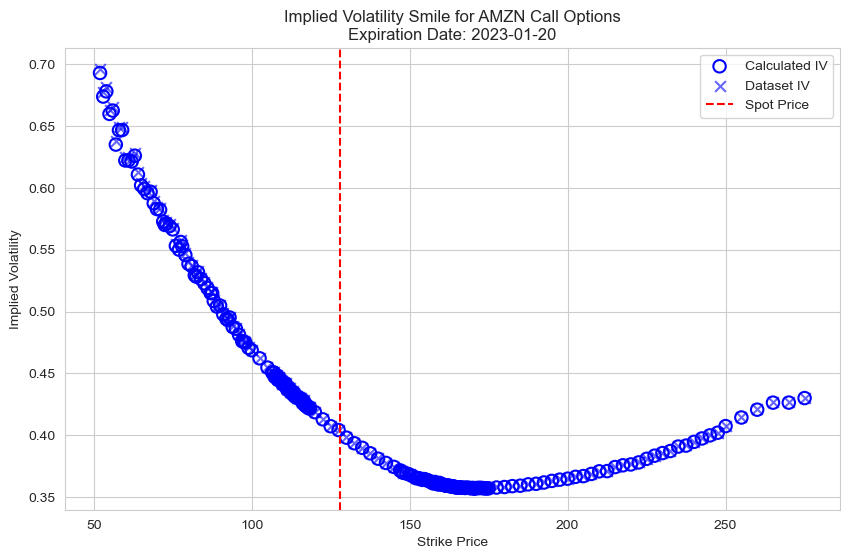

In [35]:
# Example: Use a specific target date instead of an index
# You can specify any date, and the function will find the closest available expiration date
target_date = "2023-01-30"  # Or use a date from your data

# Pick a security id
ticker = "AMZN"
exdate_id = 10

call_entries, spot_price, r, t, actual_exdate = get_implied_volatilities_for_ticker_and_exdate(ticker, target_date, verbose=True)

plot_implied_volatility_smile(call_entries, ticker, spot_price, r, t, actual_exdate)

Analyzing options for secid: 108321, ticker: NVDA
Target expiration date: 2023-01-30
Closest available expiration date: 2023-01-20
Contract length: 141 days
Closest rate entry has date 2022-09-01 and rate 3.0947%


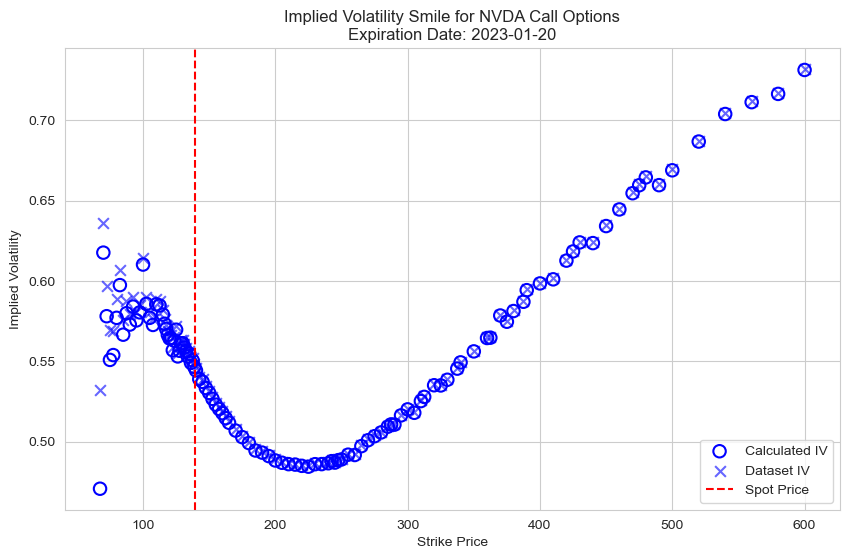

In [36]:
# Example: Use a specific target date instead of an index
# You can specify any date, and the function will find the closest available expiration date
target_date = "2023-01-30"  # Or use a date from your data

# Pick a security id
ticker = "NVDA"
exdate_id = 10

call_entries, spot_price, r, t, actual_exdate = get_implied_volatilities_for_ticker_and_exdate(ticker, target_date, verbose=True)

plot_implied_volatility_smile(call_entries, ticker, spot_price, r, t, actual_exdate)

# Implied Volatility Analysis for All Securities

Plotted ticker AMZN, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%
Plotted ticker MSFT, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%
Plotted ticker NVDA, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%
Plotted ticker TSLA, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%
Plotted ticker META, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%


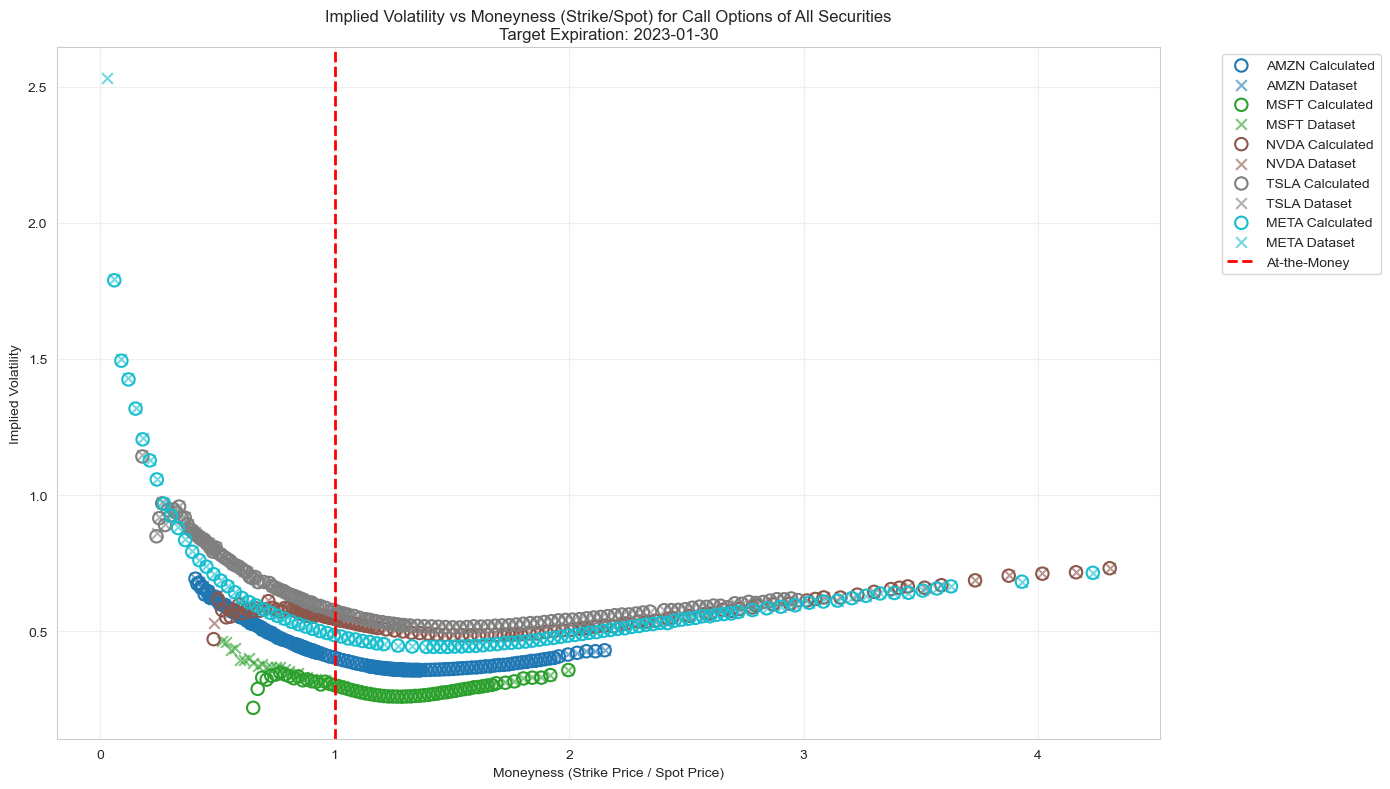

In [37]:
# Loop through all securities and analyze their implied volatilities
# This time, we'll put them all on a single plot with normalized strike prices

# Specify a target expiration date (all tickers will use the closest available date to this)
target_expiration_date = "2023-01-30"  # Adjust this to match your data range

all_tickers = df_security['ticker'].unique()

# Create a single figure for all tickers
plt.figure(figsize=(14, 8))

# Use different colors for different tickers
colors = plt.cm.tab10(np.linspace(0, 1, len(all_tickers)))

for idx, ticker in enumerate(all_tickers):
    try:
        # Use the refactored function to get implied volatilities
        call_entries, spot_price, r, t, actual_exdate = get_implied_volatilities_for_ticker_and_exdate(
            ticker, target_expiration_date, verbose = False
        )
        
        if len(call_entries) == 0:
            print(f"No call options for ticker {ticker}")
            continue
        
        # Normalize strike prices by spot price (moneyness)
        call_entries['moneyness'] = call_entries['strike_price'] / spot_price
        
        # Plot calculated IV with hollow circles
        plt.scatter(call_entries['moneyness'], call_entries['implied_volatility_calculation'], 
                    marker='o', s=80, facecolors='none', edgecolors=colors[idx], linewidths=1.5,
                    label=f'{ticker} Calculated')
        
        # Plot dataset IV with x markers
        plt.scatter(call_entries['moneyness'], call_entries['impl_volatility'], 
                    marker='x', s=60, color=colors[idx], alpha=0.6,
                    label=f'{ticker} Dataset')
        
        contract_length = int(t * 365)
        print(f"Plotted ticker {ticker}, expiration: {actual_exdate}, contract length: {contract_length} days, rate: {r*100:.4f}%")
        
    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")
        continue

# Add a vertical line at moneyness = 1 (at-the-money)
plt.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='At-the-Money')

plt.title(f"Implied Volatility vs Moneyness (Strike/Spot) for Call Options of All Securities\nTarget Expiration: {target_expiration_date}")
plt.xlabel("Moneyness (Strike Price / Spot Price)")
plt.ylabel("Implied Volatility")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


We also examine the implied volatility as a function of the time to expiration

In [38]:
# Here, we pick the option with strike price closest to the spot price (ATM) for each expiration date

def get_implied_volatilities_for_all_exdates(ticker, verbose = False):
    # Get all unique expiration dates for this ticker
    df_options_ticker = df_options[df_options['ticker'] == ticker]
    all_exdates = sorted(df_options_ticker['exdate'].unique())
    if verbose:
        print(f"Found {len(all_exdates)} unique expiration dates")

    # Get spot price for reference
    starting_date = df_options['date'].unique()[0]
    spot_price = df_security[(df_security['ticker'] == ticker) & (df_security['date'] == starting_date)]['close'].values[0]
    if verbose:
        print(f"Spot price: ${spot_price:.2f}")
    # Prepare data structures for plotting
    time_to_expiry_days = []
    calculated_ivs_atm = []
    dataset_ivs_atm = []
    strike_prices_used = []

    # Loop through each expiration date
    for exdate in tqdm(all_exdates, desc="Processing expiration dates"):
        try:
            # Use our refactored function to get implied volatilities for this expiration date
            call_entries, spot, r, t, actual_exdate = get_implied_volatilities_for_ticker_and_exdate(
                ticker, exdate, verbose= False
            )
            
            if len(call_entries) == 0:
                continue
            
            # Calculate contract length in days
            contract_length = int(t * 365)
            
            # Skip very short-dated options (less than 7 days)
            if contract_length < 7:
                continue
            
            # Find the ATM (at-the-money) option - strike closest to spot price
            call_entries['distance_to_atm'] = (call_entries['strike_price'] - spot).abs()
            atm_option = call_entries.loc[call_entries['distance_to_atm'].idxmin()]
            
            # Check if we have valid implied volatility
            if pd.notna(atm_option['implied_volatility_calculation']) and pd.notna(atm_option['impl_volatility']):
                time_to_expiry_days.append(contract_length)
                calculated_ivs_atm.append(atm_option['implied_volatility_calculation'])
                dataset_ivs_atm.append(atm_option['impl_volatility'])
                strike_prices_used.append(atm_option['strike_price'])
                
        except Exception as e:
            print(f"Error processing expiration date {exdate}: {e}")
            continue
    return time_to_expiry_days, calculated_ivs_atm, dataset_ivs_atm, strike_prices_used

Analyzing implied volatility term structure for TSLA


Processing expiration dates: 100%|██████████| 18/18 [00:00<00:00, 20.91it/s]


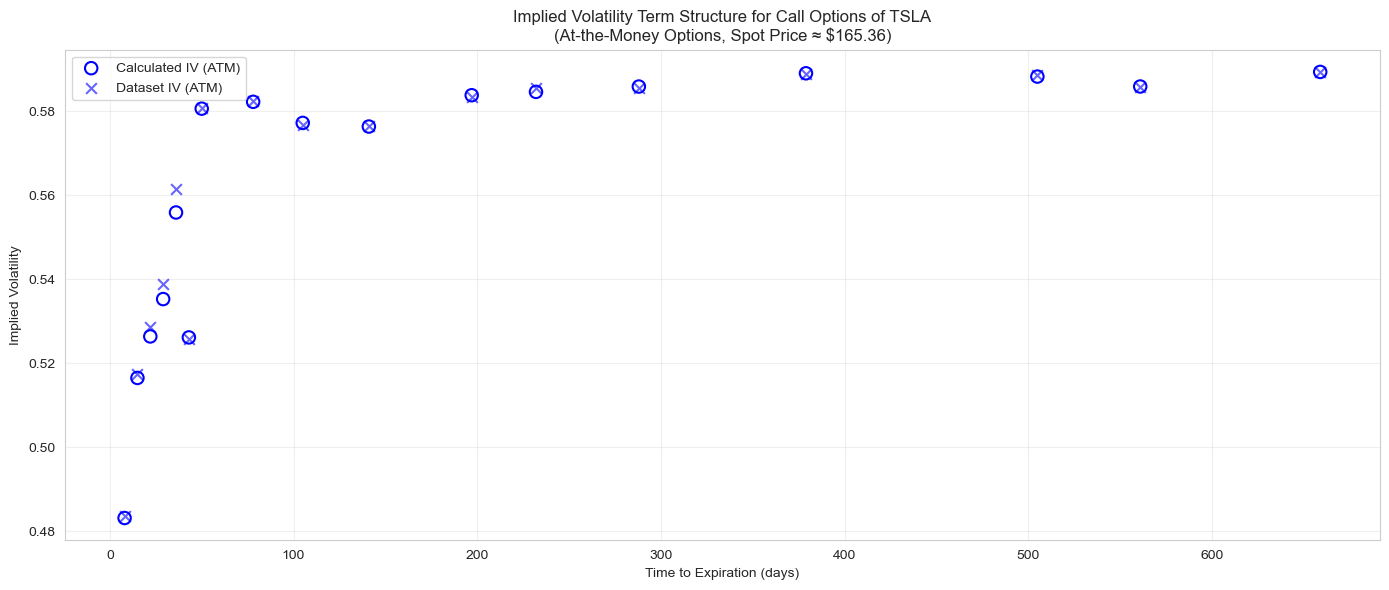

In [39]:
# Plot implied volatility as a function of time to expiration for at-the-money (ATM) options

# Pick a ticker to analyze
ticker = "TSLA"
print(f"Analyzing implied volatility term structure for {ticker}")

time_to_expiry_days, calculated_ivs_atm, dataset_ivs_atm, strike_prices_used = get_implied_volatilities_for_all_exdates(ticker = ticker)

# Plot the results
plt.figure(figsize=(14, 6))

plt.scatter(time_to_expiry_days, calculated_ivs_atm, 
            marker='o', s=80, facecolors='none', edgecolors='blue', linewidths=1.5,
            label='Calculated IV (ATM)')

plt.scatter(time_to_expiry_days, dataset_ivs_atm, 
            marker='x', s=60, color='blue', alpha=0.6,
            label='Dataset IV (ATM)')

plt.xlabel("Time to Expiration (days)")
plt.ylabel("Implied Volatility")
plt.title(f"Implied Volatility Term Structure for Call Options of {ticker}\n(At-the-Money Options, Spot Price ≈ ${spot_price:.2f})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Processing expiration dates: 100%|██████████| 19/19 [00:00<00:00, 21.27it/s]


Plotted ticker AMZN, processed 18 expiration dates


Processing expiration dates: 100%|██████████| 18/18 [00:00<00:00, 39.15it/s]


Plotted ticker MSFT, processed 17 expiration dates


Processing expiration dates: 100%|██████████| 18/18 [00:00<00:00, 31.87it/s]


Plotted ticker NVDA, processed 17 expiration dates


Processing expiration dates: 100%|██████████| 18/18 [00:00<00:00, 19.94it/s]


Plotted ticker TSLA, processed 17 expiration dates


Processing expiration dates: 100%|██████████| 17/17 [00:00<00:00, 30.45it/s]


Plotted ticker META, processed 16 expiration dates


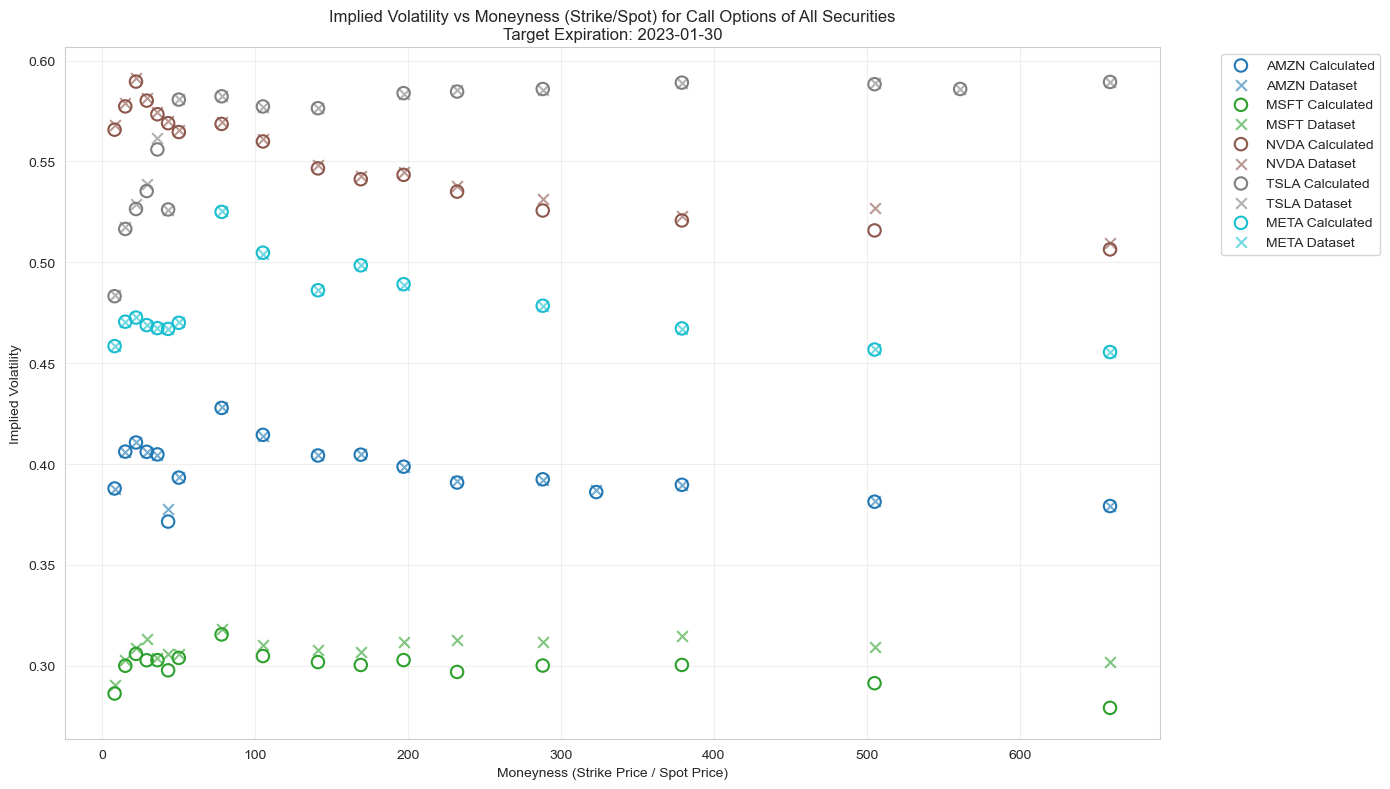

In [40]:
# Try to plot all of the tickers' IV against expiration date

# Specify a target expiration date (all tickers will use the closest available date to this)
target_expiration_date = "2023-01-30"  # Adjust this to match your data range

all_tickers = df_security['ticker'].unique()

# Create a single figure for all tickers
plt.figure(figsize=(14, 8))

# Use different colors for different tickers
colors = plt.cm.tab10(np.linspace(0, 1, len(all_tickers)))

for idx, ticker in enumerate(all_tickers):
    try:
        time_to_expiry_days, calculated_ivs_atm, dataset_ivs_atm, strike_prices_used = get_implied_volatilities_for_all_exdates(ticker = ticker)

        # Plot the results
        plt.scatter(time_to_expiry_days, calculated_ivs_atm, 
                    marker='o', s=80, facecolors='none', edgecolors=colors[idx], linewidths=1.5,
                    label=f'{ticker} Calculated')

        plt.scatter(time_to_expiry_days, dataset_ivs_atm, 
                    marker='x', s=60, color=colors[idx], alpha=0.6,
                    label=f'{ticker} Dataset')


        print(f"Plotted ticker {ticker}, processed {len(time_to_expiry_days)} expiration dates")
        
    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")
        continue

# Add a vertical line at moneyness = 1 (at-the-money)
plt.title(f"Implied Volatility vs Moneyness (Strike/Spot) for Call Options of All Securities\nTarget Expiration: {target_expiration_date}")
plt.xlabel("Moneyness (Strike Price / Spot Price)")
plt.ylabel("Implied Volatility")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Put options

Given the different theoretical basis for american put options, naively plugging the Black-Scholes info would be problematic

In [43]:
from src.binomial_tree import BinomialTreeSimulator
from scipy.optimize import brentq

n_steps = 100


def implied_volatility_put_binomial_tree(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a put option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        tree = BinomialTreeSimulator(S0=S0, K=K, T=t, r=r, sigma=sigma, n_steps=n_steps, option_type='put')
        return tree.price_american_option() - market_price

    try:
        # We give this loose bounds to speed things up
        return brentq(objective, *sigma_bounds, xtol = 1e-3, rtol=1e-3)
    except ValueError:
        return np.nan
    

Analyzing options for secid: 143439, ticker: TSLA


/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:49: RuntimeWarning: overflow encountered in scalar multiply
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)
/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:49: RuntimeWarning: invalid value encountered in scalar add
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)


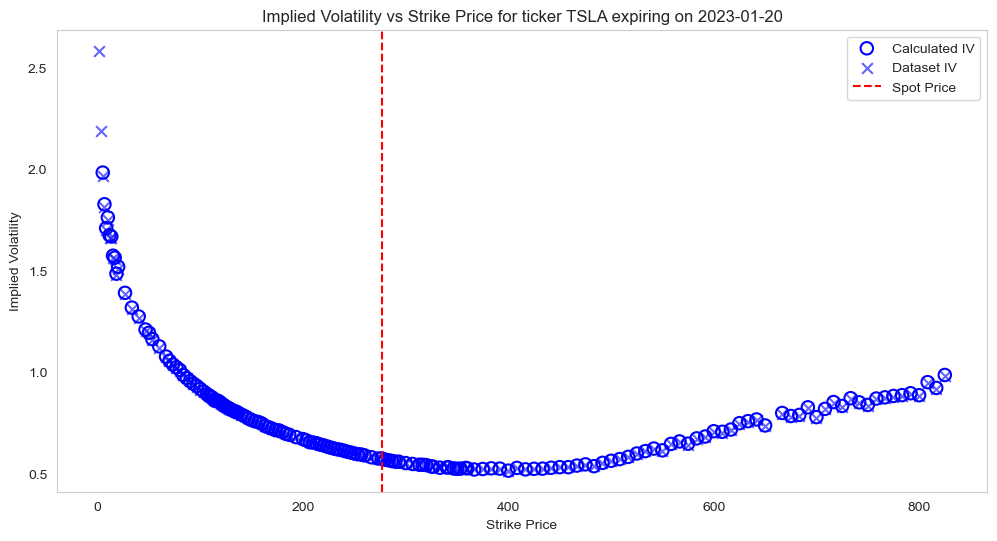

In [44]:
# Extract the data for the choosen contract length

# Pick a security id
ticker = "TSLA"
#secid = 101310
df_options_secid = df_options[df_options['ticker'] == ticker]
secid = df_security[df_security['ticker'] == ticker]['secid'].values[0]
print(f"Analyzing options for secid: {secid}, ticker: {ticker}")

spot_price = df_security[(df_security['ticker'] == ticker) & (df_security['date'] == starting_date)]['close'].values[0]


# if exdate_id is None:
# # Convert target_exdate to datetime for comparison
#     target_exdate_dt = pd.to_datetime(target_exdate)
    
#     # Find the closest available expiration date
#     available_exdates = df_options_secid['exdate'].unique()
#     available_exdates_dt = pd.to_datetime(available_exdates)
    
#     # Calculate time differences and find the closest
#     time_diffs = np.abs(available_exdates_dt - target_exdate_dt)
#     exdate_id = time_diffs.argmin()
exdate_id = 10
available_exdates = df_options_secid['exdate'].unique()
exdate = available_exdates[exdate_id]
    

option_entries = df_options_secid[(df_options_secid['exdate'] == exdate) & (df_options_secid['date'] == starting_date)].copy()
option_entries['strike_price'] = option_entries['strike_price'] / 1000  # The strike prices are given in units of 1000 * actual strike price

# examine the put entries
put_entries = option_entries[option_entries['cp_flag'] == 'P'].copy()



# calculate the implied volatility for each put option entry
put_entries['implied_volatility_calculation'] = put_entries.apply(
    lambda row: implied_volatility_put_binomial_tree(
        market_price=(row['best_bid'] + row['best_offer']) / 2,
        S0=spot_price,
        K=row['strike_price'],
        t=t,
        r=r)
    , axis=1
)

# Plot the implied volatility vs strike price
plt.scatter(put_entries['strike_price'], put_entries['implied_volatility_calculation'], 
            marker='o', s=80, facecolors='none', edgecolors='blue', linewidths=1.5,
            label='Calculated IV')

# The data also comes with implied volatility directly
plt.scatter(put_entries['strike_price'], put_entries['impl_volatility'], 
            marker='x', s=60, color='blue', alpha=0.6,
            label='Dataset IV')

# Add a vertical line at the spot price
plt.axvline(x=spot_price, color='red', linestyle='--', label='Spot Price')
plt.title(f"Implied Volatility vs Strike Price for ticker {ticker} expiring on {exdate}")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid()
plt.show()


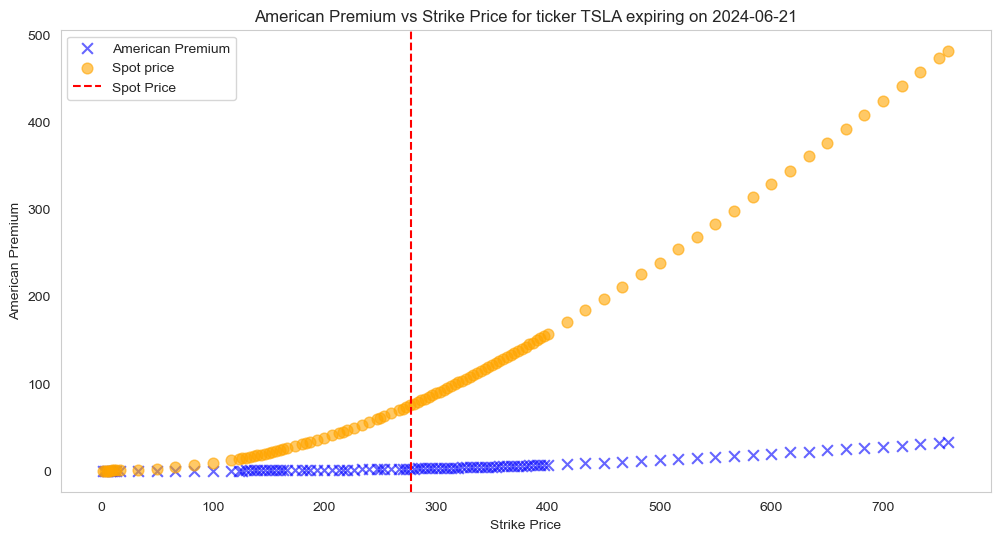

In [36]:
# We estimate the american premium using the above calculation on implied volatility

def american_premium(S0, K, t, r, sigma):
    """
    Returns the implied volatility of a put option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    tree = BinomialTreeSimulator(S0=S0, K=K, T=t, r=r, sigma=sigma, n_steps=n_steps, option_type='put')
    return tree.american_premium()
    
put_entries['american_premium'] = put_entries.apply(
    lambda row: american_premium(
        S0=spot_price,
        K=row['strike_price'],
        t=t,
        r=r,
        sigma=row['implied_volatility_calculation'])
    , axis=1
)

# The data also comes with implied volatility directly
plt.scatter(put_entries['strike_price'], put_entries['american_premium'], 
            marker='x', s=60, color='blue', alpha=0.6,
            label='American Premium')

plt.scatter(put_entries['strike_price'], 0.5 * (put_entries['best_bid'] + put_entries['best_offer']), 
            marker='o', s=60, color='orange', alpha=0.6,
            label='Spot price')

# Add a vertical line at the spot price
plt.axvline(x=spot_price, color='red', linestyle='--', label='Spot Price')
plt.title(f"American Premium vs Strike Price for ticker {ticker} expiring on {exdate}")
plt.xlabel("Strike Price")
plt.ylabel("American Premium")
plt.legend()
plt.grid()
plt.show()


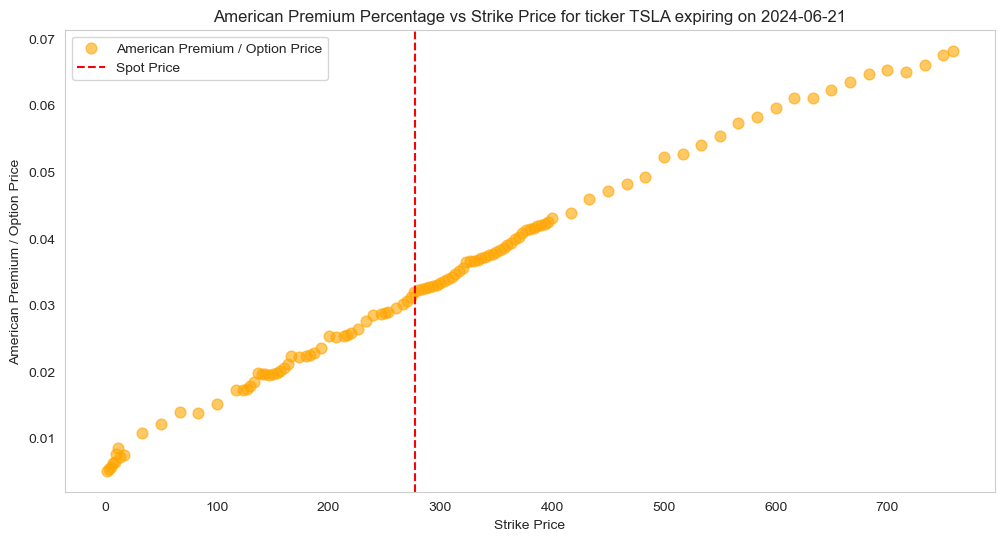

In [42]:
# Plot the premium as a percentage of the option price
plt.scatter(put_entries['strike_price'], put_entries['american_premium'] / (0.5 * (put_entries['best_bid'] + put_entries['best_offer'])), 
            marker='o', s=60, color='orange', alpha=0.6,
            label='American Premium / Option Price')

# Add a vertical line at the spot price
plt.axvline(x=spot_price, color='red', linestyle='--', label='Spot Price')
plt.title(f"American Premium Percentage vs Strike Price for ticker {ticker} expiring on {exdate}")
plt.xlabel("Strike Price")
plt.ylabel("American Premium / Option Price")
plt.legend()
plt.grid()
plt.show()

In [37]:
put_entries[['strike_price', 'american_premium', 'best_bid']]

strike_price  american_premium  best_bid
38471         10.00          0.002251      0.15
38472        100.00          0.133503      8.55
38473        116.67          0.209638     11.50
38474         11.67          0.002297      0.02
38475        123.33          0.235972     13.35
...             ...               ...       ...
38575        733.33         30.183634    453.20
38576        750.00         32.017750    470.90
38577        758.33         32.843717    478.95
38578          8.33          0.001242      0.00
38579         83.33          0.083814      5.80

[109 rows x 3 columns]